In [82]:
import os
import unittest
import requests
import urllib3
from utils_demo import *
from loguru import logger
from unittest.mock import patch
from pprint import pprint
from os.path import dirname, abspath
import warnings
warnings.filterwarnings('ignore')
from performance_data.performance_data import PhaseData, DataTable
from performance_data import DATASET_FILE
from app_decomposer import DEFAULT_CONFIGURATION, KIWI_CONFIG, CURRENT_DIR, API_DICT_TS, IOI_SAMPLING_PERIOD, DATASET_SOURCE
from app_decomposer.api_connector import request_delegator
from app_decomposer.config_parser import Configuration
from app_decomposer.api_connector import TimeSeries
from cluster_simulator.analytics import *
from loguru import logger
import simpy
from loguru import logger
import time
import numpy as np
import pandas as pd
from cluster_simulator.utils import convex_hull
from cluster_simulator.cluster import Cluster, Tier, EphemeralTier, bandwidth_share_model, compute_share_model, get_tier, convert_size
from cluster_simulator.phase import DelayPhase, ComputePhase, IOPhase
from cluster_simulator.application import Application
from cluster_simulator.analytics import display_run
from cluster_simulator.ephemeral_placement import ClusterBlackBox

Mixed Signal in virtual apps


application duration = 222.5


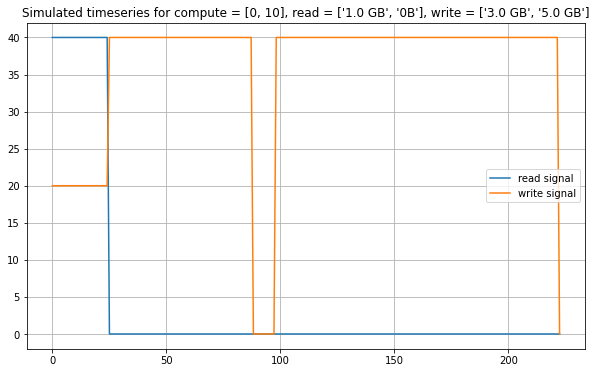

In [83]:
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs
nvram_bandwidth = {'read':  {'seq': 800, 'rand': 600},
                        'write': {'seq': 400, 'rand': 400}}
ssd_bandwidth = {'read':  {'seq': 240, 'rand': 180},
                    'write': {'seq': 100, 'rand': 100}}
hdd_bandwidth = {'read':  {'seq': 80, 'rand': 80},
                    'write': {'seq': 40, 'rand': 40}}

# registering Tiers
hdd_tier = Tier(env, 'HDD', bandwidth=hdd_bandwidth, capacity=1e12)
ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth,
                        capacity=10e9)
# registering Ephemeral Tier
bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
                        bandwidth=nvram_bandwidth, capacity=10e9)

# Define the cluster with 1 persistent and 1 ephemeral
cluster = Cluster(env, tiers=[hdd_tier], ephemeral_tier=bb)
jobid=0
# logger
#env = simpy.Environment()
logger.remove()
# Simple app: read 1GB -> compute 10s -> write 5GB
# placement
placement = [0, 0]
use_bb = [False, False]
compute=[0, 10]
read=[1e9, 0]
write=[3e9, 5e9]
# simulate the app execution
app1 = Application(env, compute=compute, read=read, write=write, data=data)
#app2 = Application(env, compute=[0, 5],  read=[2e9, 0], write=[7e9, 0], data=data)
env.process(app1.run(cluster, placement=placement, use_bb=use_bb))
#env.process(app2.run(cluster, placement=placement, use_bb=use_bb))
env.run()
print(f"application duration = {app1.get_fitness()}")

output = get_execution_signal_3(data)

sim_time = np.array(output[app1.name]["time"])
sim_read_bw = np.array(output[app1.name]["read_bw"])
sim_write_bw = np.array(output[app1.name]["write_bw"])

fig = plt.figure(figsize=(10, 6))
plt.plot(sim_time, sim_read_bw, label="read signal")
plt.plot(sim_time, sim_write_bw, label="write signal")
plt.grid(True)
plt.legend()
plt.title(f"Simulated timeseries for compute = {compute}, read = {list(map(convert_size, read))}, write = {list(map(convert_size, write))}")
plt.show()
# plot_detected_phases(jobid, merge=True, show_phases=False, 
#                     ts=(sim_time, sim_read_bw, sim_write_bw), 
#                     width=1200, height=600)

 Mixed Signal Generation

In [84]:
jobid=3918
#%%capture
logger.remove()
def decompose_ioi_job(jobid):
    with patch.object(ComplexDecomposer, 'get_job_timeseries') as mock_get_timeseries:
        with patch.object(Configuration, 'get_kc_token') as mock_get_kc_token:
            with patch.object(ComplexDecomposer, 'get_job_node_count') as mock_get_node_count:
                mock_get_timeseries.return_value = get_job_timeseries_from_file(job_id=jobid)
                mock_get_kc_token.return_value = 'token'
                mock_get_node_count.return_value = 1
                # init the job decomposer
                #cd = ComplexDecomposer(v0_threshold=0.02)
                cd = ComplexDecomposer(v0_threshold=0.01)
                return cd
# Launch decomposition on the signal
cd = decompose_ioi_job(jobid=jobid)
# Showing representation
representation = cd.get_job_representation(merge_clusters=True)
compute, reads, read_bw, writes, write_bw = representation["events"], representation["read_volumes"], representation["read_bw"], representation["write_volumes"], representation["write_bw"]
# This is the app encoding representation for Execution Simulator
print(f"compute={compute}, reads={list(map(convert_size, reads))}, writes={list(map(convert_size, writes))}")
print(f"read_bw={list(map(convert_size, read_bw))}, write_bw={list(map(convert_size, write_bw))}")

for i, value in enumerate(representation["events"]):
    phase_str = []
    for key in ["events", "read_pattern", "write_pattern", "read_operations", "write_operations", "read_bw", "write_bw"]:
        if key in ["read_bw", "write_bw"]:
            phase_str.append(f"{convert_size(representation[key][i])}/s") 
        else:
            phase_str.append(f"{representation[key][i]}")
    print(" & ".join(phase_str) + "  \\\\")
    print("\\hline")
    

        

compute=[0, 1, 8, 12, 44, 50, 54, 56], reads=['0B', '1.73 GB', '1.59 GB', '3.17 GB', '3.02 MB', '7.05 MB', '2.52 MB', '0B'], writes=['0B', '0B', '2.04 GB', '4.14 GB', '5.33 GB', '5.31 GB', '5.33 GB', '0B']
read_bw=['0B', '1.73 GB', '794.39 MB', '1.58 GB', '3.02 MB', '3.53 MB', '2.52 MB', '0B'], write_bw=['0B', '0B', '1.02 GB', '1.38 GB', '1.33 GB', '1.33 GB', '1.07 GB', '0B']
0 & Uncl & Uncl & 0 & 0 & 0B/s & 0B/s  \\
\hline
1 & Seq & Uncl & 812 & 0 & 1.73 GB/s & 0B/s  \\
\hline
8 & Seq & Seq & 1305 & 986 & 794.39 MB/s & 1.02 GB/s  \\
\hline
12 & Seq & Seq & 909 & 2000 & 1.58 GB/s & 1.38 GB/s  \\
\hline
44 & Seq & Seq & 601 & 1000 & 3.02 MB/s & 1.33 GB/s  \\
\hline
50 & Seq & Seq & 1400 & 995 & 3.53 MB/s & 1.33 GB/s  \\
\hline
54 & Seq & Seq & 500 & 1000 & 2.52 MB/s & 1.07 GB/s  \\
\hline
56 & Uncl & Uncl & 0 & 0 & 0B/s & 0B/s  \\
\hline


Normalizing and signals and scaling bw values


In [85]:
# Normalize signals to seconds and MB
timestamps = (cd.timestamps.flatten() - cd.timestamps.flatten()[0])/5
original_read =  cd.read_signal.flatten()/1e6
original_write = cd.write_signal.flatten()/1e6

read_bw_scaled = list(map(lambda x: x/1e6, read_bw))
write_bw_scaled = list(map(lambda x: x/1e6, write_bw))

Running simulation with compute/reads/writes data and fixed bw to the observed one

In [86]:
env = simpy.Environment()
nvram_bandwidth = {'read':  {'seq': 780, 'rand': 760},
                    'write': {'seq': 515, 'rand': 505}}
ssd_bandwidth = {'read':  {'seq': 1, 'rand': 1},
                    'write': {'seq': 1, 'rand': 1}}

ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth, capacity=80e9)
data = simpy.Store(env)
cluster = Cluster(env,  compute_nodes=1, cores_per_node=2,
                    tiers=[ssd_tier, nvram_tier])
app = Application(env, name=f"job#{jobid}",
                    compute=compute,
                    read=reads,
                    write=writes,
                    data=data,
                    read_bw=read_bw_scaled,
                    write_bw=write_bw_scaled)
env.process(app.run(cluster, placement=[0]*(10*len(compute))))
env.run()

Postprocessing simulation data as timeserie signals

In [87]:
output = get_execution_signal_3(data, nbr_points=len(timestamps))
sim_time = np.array(output[app.name]["time"])
sim_read_bw = np.array(output[app.name]["read_bw"])
sim_write_bw = np.array(output[app.name]["write_bw"])
print(len(sim_time))
print(len(timestamps))

70
70


In [88]:
print(np.trapz(original_read))
print(np.trapz(sim_read_bw))

print(np.abs((np.trapz(original_read)-np.trapz(sim_read_bw)))/np.trapz(original_read))

print(np.trapz(original_write))
print(np.trapz(sim_write_bw))

print(np.abs((np.trapz(original_write)-np.trapz(sim_write_bw)))/np.trapz(original_write))

6635.1994225
6501.164535
0.020200581620122355
22212.922377000003
20826.26628375
0.06242564889551827


In [89]:
plot_detected_phases(jobid, merge=True, show_phases=True, 
                     ts=(timestamps, original_read, original_write), 
                     width=1200, height=600)

In [90]:
#(sim_time, sim_read_bw, sim_write_bw)     (timestamps, original_read, original_write),
plot_detected_phases(jobid, merge=True, show_phases=False, 
                     ts=(sim_time, sim_read_bw, sim_write_bw), 
                     width=1200, height=600)

# plot_detected_phases(jobid, merge=True, show_phases=False, 
#                      ts=(np.cumsum(sim_time), np.cumsum(sim_read_bw), np.cumsum(sim_write_bw)), 
#                      width=1200, height=600)


In [91]:
plot_detected_phases(jobid, merge=True, show_phases=False, 
                     ts=(timestamps, original_read, original_write), 
                     width=1200, height=600)

Cluster Simulator

In [92]:
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs
nvram_bandwidth = {'read':  {'seq': 800, 'rand': 800},
                        'write': {'seq': 400, 'rand': 400}}
ssd_bandwidth = {'read':  {'seq': 200, 'rand': 200},
                    'write': {'seq': 100, 'rand': 100}}
hdd_bandwidth = {'read':  {'seq': 80, 'rand': 80},
                    'write': {'seq': 40, 'rand': 40}}

# registering Tiers
hdd_tier = Tier(env, 'HDD', bandwidth=hdd_bandwidth, capacity=1e12)
ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth,
                        capacity=10e9)
# registering Ephemeral Tier
bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
                        bandwidth=nvram_bandwidth, capacity=10e9)

# Define the cluster with 1 persistent and 1 ephemeral
cluster = Cluster(env, tiers=[hdd_tier], ephemeral_tier=bb)
# logger
#env = simpy.Environment()
logger.remove()
# Simple app: read 1GB -> compute 10s -> write 5GB
read = [1e9, 0]
compute = [0,  10]
write = [1e9, 5e9]
# placement
placement = [0, 0]
use_bb = [False, False]
# simulate the app execution
app1 = Application(env, compute=compute, read=read, write=write, data=data)
env.process(app1.run(cluster, placement=placement, use_bb=use_bb))
env.run()
print(f"application duration = {app1.get_fitness()}")
fig = display_run_rw(data, cluster, width=800, height=900)
fig.show()

application duration = 172.5


NameError: name 'display_run_rw' is not defined

In [ ]:
def display_run_rw(data, cluster, width=800, height=600):
    # | Monitoring| app: P6 | type: movement | cpu_usage: 1 | t_start: 281.0 | t_end: 287.5 | bandwidth_concurrency: 1 | bandwidth: 40.0 MB/s | phase_duration: 6.5 | volume: 260.0 MB | tiers: ['HDD'] | data_placement: {'placement': 'HDD', 'source': 'BB'} | init_level: {'HDD': 11740000000.0, 'BB': 8490000000.0} | tier_level: {'HDD': 12000000000.0, 'BB': 8490000000.0} | BB_level: 8490000000.0
    # | Monitoring| app: N6 | type: eviction | cpu_usage: 1 | t_start: 93.5 | t_end: 93.5 | bandwidth_concurrency: 3 | bandwidth: inf MB/s | phase_duration: 0 | volume: 740.0 MB | tiers: ['HDD'] | data_placement: {'placement': 'BB'} | init_level: {'HDD': 2740000000.0, 'BB': 10000000000.0} | tier_level: {'HDD': 2740000000.0, 'BB': 9260000000.0} | BB_level: 9260000000.0

    jet_colors = colors.PLOTLY_SCALES['Viridis']
    apps = list(set(list(data['app'] for data in data.items)))
    # sort by app key
    items = sorted(data.items, key=itemgetter('app'))
    # list of apps
    list_apps = [app for app, _ in groupby(items,  key=itemgetter('app'))]
    # list Burst Buffers
    bb_tier = [cluster.ephemeral_tier.name + " ("+convert_size(cluster.ephemeral_tier.capacity.capacity)+")"] if cluster.ephemeral_tier else []

    subplots_list = list_apps + bb_tier + [tier.name + " ("+convert_size(tier.capacity.capacity)+")" for tier in cluster.tiers] + ["CPU Cores"]

    fig = make_subplots(rows=len(subplots_list), cols=1, shared_xaxes=True,
                        # vertical_spacing=0.2,
                        subplot_titles=subplots_list)

    # iterate on apps to plot their dataflows
    i = 1
    for app, app_elements in groupby(items,  key=itemgetter('app')):
        # print(f"----------{app}----------")
        # app_color = DEFAULT_COLORS[i]
        offset = 0

        # x_app = []
        # y_app = []
        x_app_read = []
        y_app_read = []
        x_app_write = []
        y_app_write = []
        text = []

        x_mvt = []
        y_mvt = []
        text_mvt = []

        for phase in app_elements:
            if phase['type'] not in ['movement']:
                if phase["type"] == "read":
                    x_app_read.append(phase["t_start"])
                    x_app_read.append(phase["t_end"])
                    y_app_read.append(phase["bandwidth"])
                    y_app_read.append(phase["bandwidth"])
                    x_app_write.append(phase["t_start"])
                    x_app_write.append(phase["t_end"])
                    y_app_write.append(0)
                    y_app_write.append(0)
                    
                elif phase["type"] == "write":
                    x_app_read.append(phase["t_start"])
                    x_app_read.append(phase["t_end"])
                    y_app_read.append(0)
                    y_app_read.append(0)
                    x_app_write.append(phase["t_start"])
                    x_app_write.append(phase["t_end"])
                    y_app_write.append(phase["bandwidth"])
                    y_app_write.append(phase["bandwidth"])
                    
                elif phase["type"] == "compute":                
                    x_app_read.append(phase["t_start"])
                    x_app_read.append(phase["t_end"])
                    y_app_read.append(phase["bandwidth"])
                    y_app_read.append(phase["bandwidth"])
                    x_app_write.append(phase["t_start"])
                    x_app_write.append(phase["t_end"])
                    y_app_write.append(phase["bandwidth"])
                    y_app_write.append(phase["bandwidth"])
                    
                placement = "|to/from:"+phase["data_placement"]["placement"] if phase["data_placement"] else ''

                text.append(phase["type"].upper() + placement + "|volume="+convert_size(phase["volume"]))
                text.append(phase["type"].upper() + placement + "|volume="+convert_size(phase["volume"]))

            if phase["type"] in ['movement']:
                x_mvt.append(phase["t_start"])
                x_mvt.append(phase["t_end"])
                y_mvt.append(phase["bandwidth"])
                y_mvt.append(phase["bandwidth"])
                placement = "|in:"+phase["data_placement"]["placement"] if phase["data_placement"] else ''
                source = ""
                if "data_placement" in phase and "source" in phase["data_placement"]:
                    source = "|from:"+phase["data_placement"]["source"]

                text_mvt.append(phase["type"].upper() + placement + source + "|volume="+convert_size(phase["volume"]))
                text_mvt.append(phase["type"].upper() + placement + "|volume="+convert_size(phase["volume"]))

            # plot the app phases
        fig.append_trace(go.Scatter(x=np.array(x_app_read), y=np.array(y_app_read),
                                    text=text,
                                    textposition="top center",
                                    name="(R) app#"+app, line_shape='linear'),
                                    #line=dict(color=jet_colors[i][1])),
                                    row=i, col=1)
        fig.append_trace(go.Scatter(x=np.array(x_app_write), y=np.array(y_app_write),
                                    text=text,
                                    textposition="top center",
                                    name="(W) app#"+app, line_shape='linear'),
                                    #line=dict(color=jet_colors[i][1])),
                                    row=i, col=1)
        fig.append_trace(go.Scatter(x=np.array(x_mvt), y=np.array(y_mvt),
                                    text=text_mvt,
                                    textposition="top center",
                                    name=app + " mvt", #line_shape='linear',
                                    line={'shape':'linear','dash': 'dot'}), row=i, col=1)
        fig['layout']['yaxis'+str(i)]['title'] = 'dataflow in MB/s'
        fig.update_xaxes(title_text="time in s")
        i += 1

    x_phase = []
    y_phase = []
    x_tiers = [0]
    x_evict = []
    capacities = dict()
    text = []
    text_evict = []
    cpu_phase = []
    buffer_storage = dict()
    storage = dict()
    bb_levels = dict()
    storage_levels = dict()
    eviction_levels = dict()
    for phase in data.items:

        x_phase.append([phase["t_start"], phase["t_end"]])
        y_phase.append(phase["cpu_usage"])
        x_tiers.append(phase["t_start"])
        x_tiers.append(phase["t_end"])

        # feeding eviction dict
        if phase["type"] == "eviction":
            if "source" in phase["data_placement"]:
                tier = phase["data_placement"]["source"]
                eviction_levels.setdefault(tier, []).append([phase["init_level"][tier], phase["tier_level"][tier]])
                x_evict.append([phase["t_start"], phase["t_end"]])
                text_evict.append(phase["type"].upper() + "|IN:"+tier + "|volume="+convert_size(phase["init_level"][tier]-phase["tier_level"][tier]))
                text_evict.append(phase["type"].upper() + "|IN:"+tier + "|volume="+convert_size(phase["init_level"][tier]-phase["tier_level"][tier]))

        tier_indication = "|" + phase["data_placement"]["placement"] if phase["data_placement"] else ''

        text.append(phase["app"] + "|" + phase["type"].capitalize() + tier_indication + " | +volume="+convert_size(phase["volume"]))

        # feeding tiers level
        for tier in phase["tiers"]:
            if tier not in storage_levels.keys():
                storage_levels[tier] = dict()
            storage_levels[tier][phase["t_start"]] = phase["init_level"][tier]
            storage_levels[tier][phase["t_end"]] = phase["tier_level"][tier]
            storage.setdefault(tier, []).append(phase["init_level"][tier])
            storage.setdefault(tier, []).append(phase["tier_level"][tier])

        # feeding buffer level
        if cluster.ephemeral_tier:
            bb_tier = cluster.ephemeral_tier.name
            if bb_tier+"_level" in phase:
                bb_levels[phase["t_start"]] = phase["init_level"][bb_tier]
                bb_levels[phase["t_end"]] = phase["tier_level"][bb_tier]
                buffer_storage.setdefault(bb_tier, []).append([phase["init_level"][bb_tier], phase["tier_level"][bb_tier]])

    # Burst Buffer level tracing
    for bb in buffer_storage.keys():
        bb_capacity = cluster.ephemeral_tier.capacity.capacity
        # for segment, level in zip(x_phase, buffer_storage[bb]):
        #     fig.append_trace(go.Scatter(x=np.array(segment),
        #                                 y=level,
        #                                 text=text,
        #                                 textposition="top center",
        #                                 name=bb, line_shape='linear', showlegend=False), row=i, col=1)
        fig.append_trace(go.Scatter(x=np.array(list(bb_levels.keys())),
                                    y=100*bb_capacity*np.array(list(bb_levels.values()))/bb_capacity/100,
                                    text=text,
                                    textposition="top center",
                                    name=bb, line_shape='linear', showlegend=False), row=i, col=1)

        if bb in eviction_levels:
            for segment, level in zip(x_evict, eviction_levels[bb]):
                # fig.append_trace(go.Scatter(x=np.array(segment),
                #                             y=level,
                #                             text=text,
                #                             textposition="top center",
                #                             name=bb, line=dict(color='red', width=3, dash='dot'), showlegend=False), row=i, col=1)
                fig.append_trace(go.Scatter(x=np.array(segment), y=np.array(level),
                                            text=text_evict,
                                            textposition="top center",
                                            name=" Eviction",
                                            line=dict(shape='linear', color="black"),
                                            showlegend=False), row=i, col=1)
                # fig.add_shape(type="line", x0=segment[0], y0=level[0], x1=segment[1], y1=level[1],
                #               line=dict(width=3, color="black"),
                #               row=i, col=1)
                # fig.add_annotation(ax=segment[0],
                #                    ay=level[0],
                #                    x=segment[1],
                #                    y=level[1],
                #                    xref='x',

                #                    yref='y',
                #                    axref='x',
                #                    ayref='y',
                #                    text='',  # if you want only the arrow
                #                    showarrow=True,
                #                    arrowhead=3,
                #                    arrowsize=1,
                #                    arrowwidth=1,
                #                    arrowcolor='black', row=i, col=1)

        # fig.append_trace(go.Scatter(x=np.array(list(bb_levels.keys())),
        #                             y=100*bb_capacity*np.array(list(bb_levels.values()))/bb_capacity/100,
        #                             text=text,
        #                             textposition="top center",
        #                             name=bb, line_shape='linear', showlegend=False), row=i, col=1)
        # fig.append_trace(go.Scatter(x=np.array(x_tiers),
        #                             y=100*np.array(buffer_storage[bb])/bb_capacity,
        #                             text=text,
        #                             textposition="top center",
        #                             name=bb, line_shape='linear', showlegend=False), row=i, col=1)
        fig['layout']['yaxis' + str(i)]['title'] = bb + ' usage in Bytes'
        i += 1

    for tier in storage.keys():
        # retrieve capacities
        tier_capacity = [cluster.tiers[j].capacity.capacity for j, ctier in enumerate(cluster.tiers) if ctier.name == tier][0]
        fig.append_trace(go.Scatter(x=np.array(list(storage_levels[tier].keys())),
                                    y=100*tier_capacity*np.array(list(storage_levels[tier].values()))/tier_capacity/100,
                                    text=text,
                                    textposition="top center",
                                    name=tier, line_shape='linear', showlegend=False), row=i, col=1)
        # fig.append_trace(go.Scatter(x=np.array(x_tiers),
        #                             y=100*np.array(storage[tier])/tier_capacity,
        #                             text=text,
        #                             textposition="top center",
        #                             name=tier, line_shape='linear', showlegend=False), row=i, col=1)
        fig['layout']['yaxis' + str(i)]['title'] = tier + ' usage in Bytes'

        i += 1

    # CPU tracing
    points, values = accumulate_intervals(x_phase, y_phase)
    fig.append_trace(go.Scatter(x=np.array(points), y=np.array(values),
                                line_shape='hv', showlegend=False), row=i, col=1)

    fig.append_trace(go.Scatter(x=np.array([points[0], points[-1]]), y=np.array([cluster.compute_cores.capacity]*2), text=["Maximum available cores in cluster=" + str(cluster.compute_cores.capacity)]*2, line_shape='hv', showlegend=False,
                                line=dict(color='red', width=3, dash='dot')), row=i, col=1)
    fig['layout']['yaxis'+str(i)]['title'] = 'CPU usage'
    i += 1

    fig.update_layout(width=width, height=height, title_text="State of the Cluster")



    return fig